This notebook aims to discuss how to calculate the lightning counts in the TROPOMI swath.

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

from scipy import stats
from satpy import Scene
import proplot as pplt
from scipy.optimize import linprog
from pyresample.geometry import GridDefinition

## Read data

In [2]:
def read_s5p(filename):
    """Read TROPOMI data"""
    scn = Scene([filename], reader='tropomi_l2')
    scn.load(['time_utc', 'longitude', 'latitude', 'nitrogendioxide_tropospheric_column'])
    overpass_time = pd.to_datetime(scn['time_utc'].where(scn['latitude'].mean('x') >= 60, drop=True)).mean()

    return scn,scn['longitude'], scn['latitude'], overpass_time

In [3]:
filename = '../data/tropomi/S5P_NRTI_L2__NO2____20220612T215110_20220612T215610_24168_02_020301_20220612T234455.nc'

scn, lons, lats, t_overpass = read_s5p(filename)

Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/surface_pressure
Can't load ancillary dataset /PRODUCT/SUPPORT_DATA/INPUT_DATA/surface_pressure


## Goal

- Check whether the points are within the swath corretly
- Count the inside points within defined grid, such as 0.5 x 0.5 deg grid.

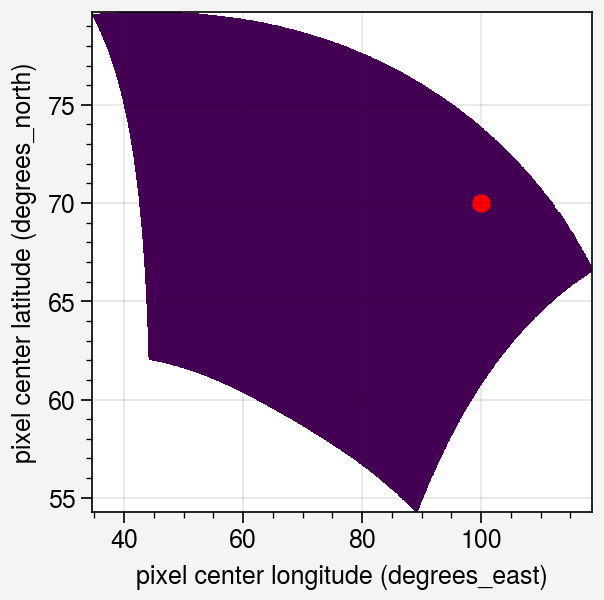

In [4]:
fig, ax = pplt.subplots()

ax.pcolormesh(scn['longitude'], scn['latitude'], xr.full_like(scn['longitude'], 1), cmap='viridis')
ax.scatter(100, 70, c='r')

## Method 1 (accurate but slow)

In [5]:
def in_hull(points, x):
    # https://stackoverflow.com/a/43564754/2912349
    n_points = len(points)
    c = np.zeros(n_points)
    A = np.r_[points.T, np.ones((1, n_points))]
    b = np.r_[x, np.ones(1)]
    lp = linprog(c, A_eq=A, b_eq=b)

    return lp.success

In [6]:
# because it's time consuming to use the exact swath points data
#       we can coarsen it first
coarse_lons = scn['longitude'].coarsen(y=scn['longitude'].sizes['y']//100,
                                        x=scn['longitude'].sizes['x']//100,
                                        boundary="trim").mean()

coarse_lats = scn['latitude'].coarsen(y=scn['latitude'].sizes['y']//100,
                                        x=scn['latitude'].sizes['x']//100,
                                        boundary="trim").mean()

# get 1D lon and lat of tropomi pixels
points = np.c_[coarse_lons.values.ravel(), coarse_lats.values.ravel()]

# check whether the lightning point is within the subset of tropomi swath
inside = in_hull(points, [100, 70])

inside

True

Although it's fast to check one point, but it would be slow if we have thousands points ...

## Method 2 (fast and enough accurate)

Instead we can define a lon/lat grid and resample the swath data to the grid first, which is a mask.

Because calculating the counts in lon/lat is fast by `stats.binned_statistic_2d()`, the masked statistics should be nearly as same as method1 is the grid resolution is high enough.

This method is also useful to check the gridded lightning distribution in swaths.

In [7]:
# create array full of 1 to create mask
scn['mask'] = xr.full_like(scn['longitude'], 1)

# create target grid, increase the resolution higher than 0.05 will get more accurate results
lon_resolution = 0.5
lat_resolution = 0.5
lon_bnd = np.arange(-180, 180+lon_resolution, lon_resolution)
lat_bnd = np.arange(60, 90+lat_resolution, lat_resolution)
lon_center = np.convolve(lon_bnd, np.ones(2), 'valid') / 2 
lat_center = np.convolve(lat_bnd, np.ones(2), 'valid') / 2 

# define the arctic grid
lats, lons = np.meshgrid(lat_center, lon_center)
arctic_grid = GridDefinition(lons=lons, lats=lats)

scn_resample = scn.resample(arctic_grid)

In [8]:
def random_lat_lon(n=1, lat_min=-90., lat_max=90., lon_min=-180., lon_max=180.):
    """
    this code produces an array with pairs lat, lon
    """
    lat = np.random.uniform(lat_min, lat_max, n)
    lon = np.random.uniform(lon_min, lon_max, n)

    return np.array(tuple(zip(lon, lat)))

In [9]:
random_lightning = random_lat_lon(1000)

lightning_counts = xr.DataArray(stats.binned_statistic_2d(random_lightning[:, 0], random_lightning[:, 1], None,
                                'count', bins=[lon_bnd,lat_bnd]).statistic,
                                dims=['y', 'x'])

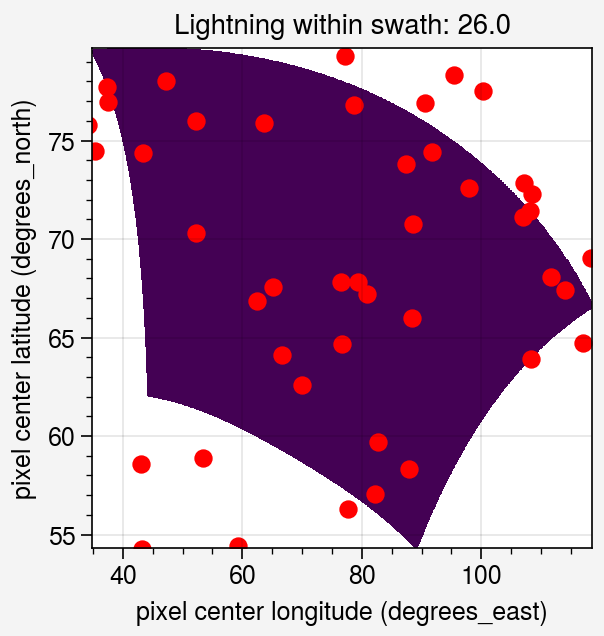

In [10]:
fig, ax = pplt.subplots()

title = 'Lightning within swath: ' + str(lightning_counts.where(scn_resample['mask'].fillna(0)).sum().values)

ax.pcolormesh(scn['longitude'], scn['latitude'], xr.full_like(scn['longitude'], 1), cmap='viridis')
ax.scatter(random_lightning[:, 0], random_lightning[:, 1], c='r')
ax.format(xlim=(scn['longitude'].min(), scn['longitude'].max()), ylim=(scn['latitude'].min(), scn['latitude'].max()),
         title=title)